In [1]:
import warnings
import matplotlib.pyplot as plt
from utils import *

warnings.filterwarnings('ignore')

In [2]:
# base 데이터 수집
try:
    # crawling(selenium)
    path = 'https://sisul.jnu.ac.kr/sisul/13422/subview.do'
    df = get_crawling(path)
    # 17년도 이후 데이터 사용
    df = df[df['year']>=2017]
except:
    # selenium 에러 시
    df = pd.read_csv('./crawling_results.csv')

100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


In [3]:
display(df.isna().sum())
# 결측치 처리
df.fillna(method='bfill', inplace=True)
display(df.isna().sum())

year     0
month    0
using    2
dtype: int64

year     0
month    0
using    0
dtype: int64

In [4]:
# data augmentation(월별 --> 시간별)
df_for_aug = pd.read_csv('../raw/한국전력거래소_광주시 일별 시간대별 전력거래량.csv', encoding='cp949')
df_for_aug.columns = ['date', 'hour', 'use']

split_date(df_for_aug, drop=True)

df_for_aug = df_for_aug[df_for_aug['year']==2022].drop('year', axis=1)
df_for_aug['hour'] = df_for_aug.pop('hour')
df_for_aug['use'] = df_for_aug.pop('use')

lst_ratio = []

for year in df['year'].unique():
    for month in df[df['year']==year]['month'].unique():
        div = df_for_aug[df_for_aug['month']==month]['use'].sum()
        ratio = df[np.logical_and(df['year']==year, df['month']==month)]['using'].values[0] / div
        lst_ratio.append(ratio)

df['ratio'] = lst_ratio

lst_df = []

for year in df['year'].unique():
    df_for_aug['year'] = int(year)
    lst_df.append(df_for_aug.copy())

lst_df[-1] = lst_df[-1][lst_df[-1]['month'] <= 5]

for i in range(len(lst_df)-1):
    if i==0:
        aug_df = pd.concat([lst_df[i], lst_df[i+1]])
    else:
        aug_df = pd.concat([aug_df, lst_df[i+1]])

for year in df['year'].unique():
    for month in df[df['year']==year]['month'].unique():
        aug_df.loc[year_month_condition(aug_df, year, month), 'use'] *= df[year_month_condition(df, year, month)]['ratio'].values[0]

for col in aug_df.columns[:-1]:
    aug_df[col] = aug_df.pop(col)

display(aug_df.isna().sum())

year     0
month    0
day      0
hour     0
use      0
dtype: int64

In [5]:
# 17~21년 온도, 습도 데이터 추가
for i in range(2017,2021):
    if i==2017:
        climate = pd.concat([pd.read_csv(f'../raw/{i}_climate.csv', encoding='cp949').drop(['지점','지점명'], axis=1), pd.read_csv(f'../raw/{i+1}_climate.csv', encoding='cp949').drop(['지점','지점명'], axis=1)])
    else:
        climate = pd.concat([climate, pd.read_csv(f'../raw/{i+1}_climate.csv', encoding='cp949').drop(['지점','지점명'], axis=1)])


climate.columns = ['date', 'temp', 'humid']
split_date(climate, hour=True)
climate['temp'] = climate.pop('temp')
climate['humid'] = climate.pop('humid')
climate = climate.drop(index=0).reset_index().drop('index', axis=1)
climate.fillna(method='bfill', inplace=True)

for idx in climate[climate['hour']==0].index:
    climate.loc[idx, 'year'] = climate.iloc[idx-1]['year']
    climate.loc[idx, 'month'] = climate.iloc[idx-1]['month']
    climate.loc[idx, 'day'] = climate.iloc[idx-1]['day']
    climate.loc[idx, 'hour'] = 24

climate = climate.drop(index=climate[np.logical_and(climate['month']==2, climate['day']==29)].index)
climate = climate.drop(index=climate[np.logical_and(climate['year']==2021, climate['month']>5)].index)
climate = climate.reset_index().drop('index', axis=1)

aug_df = pd.merge(aug_df, climate, how='left', on=['year','month','day','hour'])
aug_df.fillna(method='bfill', inplace=True)

In [6]:
display(aug_df.head(3), aug_df.tail(3))

,year,month,day,hour,use,temp,humid
0,2017,1,1,1,134.459023,1.3,93.0
1,2017,1,1,2,133.912851,0.9,95.0
2,2017,1,1,3,134.201172,0.7,95.0


,year,month,day,hour,use,temp,humid
38661,2021,5,31,22,90.623291,22.8,51.0
38662,2021,5,31,23,90.582110,21.8,55.0
38663,2021,5,31,24,76.696808,21.2,56.0


In [7]:
check_path('../temp')
aug_df.to_csv('../temp/dataset_01[시간별전력온습도].csv', index=False)

# 데이터 증강(2)
 - 전체 공간 데이터 --> 공간사용목적별 데이터

In [8]:
# data augmentation(전체 공간 --> 공간별)
df_aug = pd.read_csv('../raw/KOSIS_항목별전력사용량_연도월시간.csv')

ddf = df_aug[df_aug['항목']=='숙박업']
dddf = df_aug[df_aug['항목']=='연구개발업']
last = df_aug[np.logical_and(df_aug['항목'] != '숙박업', df_aug['항목'] != '연구개발업')]

ddf_1 = ddf.copy()
ddf_2 = ddf.copy()
ddf_1['항목'] = '공용공간'
ddf_2['항목'] = '학생자율'
ddf = pd.concat([ddf_1, ddf_2])

ddf_1 = dddf.copy()
ddf_2 = dddf.copy()
ddf_1['항목'] = '교수연구'
ddf_2['항목'] = '연구공간'
dddf = pd.concat([ddf_1, ddf_2])

df_aug = pd.concat([ddf, dddf])
df_aug = pd.concat([df_aug, last])

df_aug.loc[df_aug['항목']=='교육 서비스업', '항목'] = '강의지원'
df_aug.loc[df_aug['항목']=='컴퓨터 프로그래밍/ 시스템 통합 및 관리업', '항목'] = '학술지원'
df_aug.loc[df_aug['항목']=='공공행정/ 국방 및 사회보장 행정', '항목'] = '행정지원'
df_aug = df_aug.sort_values(['month','hour']).reset_index().drop('index', axis=1)

# 국내 참고 논문(KCI) 결과를 반영하여 가중치 부여

df_aug.loc[df_aug['항목']=='강의지원', '2017 년'] *= 3
df_aug.loc[df_aug['항목']=='강의지원', '2018 년'] *= 3
df_aug.loc[df_aug['항목']=='강의지원', '2019 년'] *= 3
df_aug.loc[df_aug['항목']=='강의지원', '2020 년'] *= 3
df_aug.loc[df_aug['항목']=='강의지원', '2021 년'] *= 3

df_aug.loc[df_aug['항목']=='교수연구', '2017 년'] *= 1.6
df_aug.loc[df_aug['항목']=='교수연구', '2018 년'] *= 1.6
df_aug.loc[df_aug['항목']=='교수연구', '2019 년'] *= 1.6
df_aug.loc[df_aug['항목']=='교수연구', '2020 년'] *= 1.6
df_aug.loc[df_aug['항목']=='교수연구', '2021 년'] *= 1.6

df_aug.loc[df_aug['항목']=='연구공간', '2017 년'] *= 27
df_aug.loc[df_aug['항목']=='연구공간', '2018 년'] *= 27
df_aug.loc[df_aug['항목']=='연구공간', '2019 년'] *= 27
df_aug.loc[df_aug['항목']=='연구공간', '2020 년'] *= 27
df_aug.loc[df_aug['항목']=='연구공간', '2021 년'] *= 27

df_aug.loc[df_aug['항목']=='학술지원', '2017 년'] *=22.7
df_aug.loc[df_aug['항목']=='학술지원', '2018 년'] *=22.7
df_aug.loc[df_aug['항목']=='학술지원', '2019 년'] *=22.7
df_aug.loc[df_aug['항목']=='학술지원', '2020 년'] *=22.7
df_aug.loc[df_aug['항목']=='학술지원', '2021 년'] *=22.7

df_aug.loc[df_aug['항목']=='행정지원', '2017 년'] *= 13
df_aug.loc[df_aug['항목']=='행정지원', '2018 년'] *= 13
df_aug.loc[df_aug['항목']=='행정지원', '2019 년'] *= 13
df_aug.loc[df_aug['항목']=='행정지원', '2020 년'] *= 13
df_aug.loc[df_aug['항목']=='행정지원', '2021 년'] *= 13

aug_17 = df_aug[['항목', 'month', 'hour', '2017 년']]
aug_17['year'] = 2017
aug_17.rename(columns={'2017 년':'elec'}, inplace=True)

aug_18 = df_aug[['항목', 'month', 'hour', '2018 년']]
aug_18['year'] = 2018
aug_18.rename(columns={'2018 년':'elec'}, inplace=True)

aug_19 = df_aug[['항목', 'month', 'hour', '2019 년']]
aug_19['year'] = 2019
aug_19.rename(columns={'2019 년':'elec'}, inplace=True)

aug_20 = df_aug[['항목', 'month', 'hour', '2020 년']]
aug_20['year'] = 2020
aug_20.rename(columns={'2020 년':'elec'}, inplace=True)

aug_21 = df_aug[['항목', 'month', 'hour', '2021 년']]
aug_21['year'] = 2021
aug_21.rename(columns={'2021 년':'elec'}, inplace=True)
aug_21 = aug_21[aug_21['month']<=5]

df_aug = pd.concat([aug_17, aug_18])
df_aug = pd.concat([df_aug, aug_19])
df_aug = pd.concat([df_aug, aug_20])
df_aug = pd.concat([df_aug, aug_21])

In [9]:
year_lst = []
month_lst = []
hour_lst = []
ratio_lst1 = []
ratio_lst2 = []
ratio_lst3 = []
ratio_lst4 = []
ratio_lst5 = []
ratio_lst6 = []
ratio_lst7 = []

for year in tqdm(range(2017,2022)):
    if year==2021:
        for month in range(1,6):
            for hour in range(1, 25):
                df_temp = df_aug[np.logical_and(np.logical_and(df_aug['year']==year, df_aug['month']==month), df_aug['hour']==hour)]
                year_lst.append(year)
                month_lst.append(month)
                hour_lst.append(hour)
                df_temp['elec'] /= df_temp[df_temp['항목']=='공용공간']['elec'].values[0]

                ratio_lst1.append(df_temp[df_temp['항목']=='공용공간']['elec'].values[0])
                ratio_lst2.append(df_temp[df_temp['항목']=='학생자율']['elec'].values[0])
                ratio_lst3.append(df_temp[df_temp['항목']=='교수연구']['elec'].values[0])
                ratio_lst4.append(df_temp[df_temp['항목']=='연구공간']['elec'].values[0])
                ratio_lst5.append(df_temp[df_temp['항목']=='학술지원']['elec'].values[0])
                ratio_lst6.append(df_temp[df_temp['항목']=='행정지원']['elec'].values[0])
                ratio_lst7.append(df_temp[df_temp['항목']=='강의지원']['elec'].values[0])
    else:
        for month in range(1,13):
            for hour in range(1, 25):
                df_temp = df_aug[np.logical_and(np.logical_and(df_aug['year']==year, df_aug['month']==month), df_aug['hour']==hour)]
                year_lst.append(year)
                month_lst.append(month)
                hour_lst.append(hour)
                df_temp['elec'] /= df_temp[df_temp['항목']=='공용공간']['elec'].values[0]

                ratio_lst1.append(df_temp[df_temp['항목']=='공용공간']['elec'].values[0])
                ratio_lst2.append(df_temp[df_temp['항목']=='학생자율']['elec'].values[0])
                ratio_lst3.append(df_temp[df_temp['항목']=='교수연구']['elec'].values[0])
                ratio_lst4.append(df_temp[df_temp['항목']=='연구공간']['elec'].values[0])
                ratio_lst5.append(df_temp[df_temp['항목']=='학술지원']['elec'].values[0])
                ratio_lst6.append(df_temp[df_temp['항목']=='행정지원']['elec'].values[0])
                ratio_lst7.append(df_temp[df_temp['항목']=='강의지원']['elec'].values[0])


df_result = pd.DataFrame()
df_result['year'] = year_lst
df_result['month'] = month_lst
df_result['hour'] = hour_lst
df_result['ratio1'] = ratio_lst1
df_result['ratio2'] = ratio_lst2
df_result['ratio3'] = ratio_lst3
df_result['ratio4'] = ratio_lst4
df_result['ratio5'] = ratio_lst5
df_result['ratio6'] = ratio_lst6
df_result['ratio7'] = ratio_lst7

df_result['sum'] = df_result['ratio1'] + df_result['ratio2'] + df_result['ratio3'] + df_result['ratio4'] + df_result['ratio5'] + df_result['ratio6'] + df_result['ratio7']

100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


In [10]:
df_final = pd.merge(aug_df, df_result, how='left', left_on=['year', 'month', 'hour'], right_on=['year','month','hour']).rename(
    columns={
        'ratio1': '공용공간',
        'ratio2': '학생자율',
        'ratio3': '교수연구',
        'ratio4': '연구공간',
        'ratio5': '학술지원',
        'ratio6': '행정지원',
        'ratio7': '강의지원',
    }
)
df_final.head()

,year,month,day,hour,use,temp,humid,공용공간,학생자율,교수연구,연구공간,학술지원,행정지원,강의지원,sum
0,2017,1,1,1,134.459023,1.3,93.0,1.0,1.0,1.226667,20.700000,19.851373,9.380392,2.350000,55.508431
1,2017,1,1,2,133.912851,0.9,95.0,1.0,1.0,1.283663,21.661811,20.904787,9.807492,2.463059,58.120812
2,2017,1,1,3,134.201172,0.7,95.0,1.0,1.0,1.346256,22.718062,22.000000,10.308370,2.573789,60.946476
3,2017,1,1,4,133.930724,0.3,97.0,1.0,1.0,1.392898,23.505155,22.804009,10.676976,2.635739,63.014777
4,2017,1,1,5,134.012838,-0.3,97.0,1.0,1.0,1.406228,23.730104,22.909458,10.915802,2.657439,63.619031


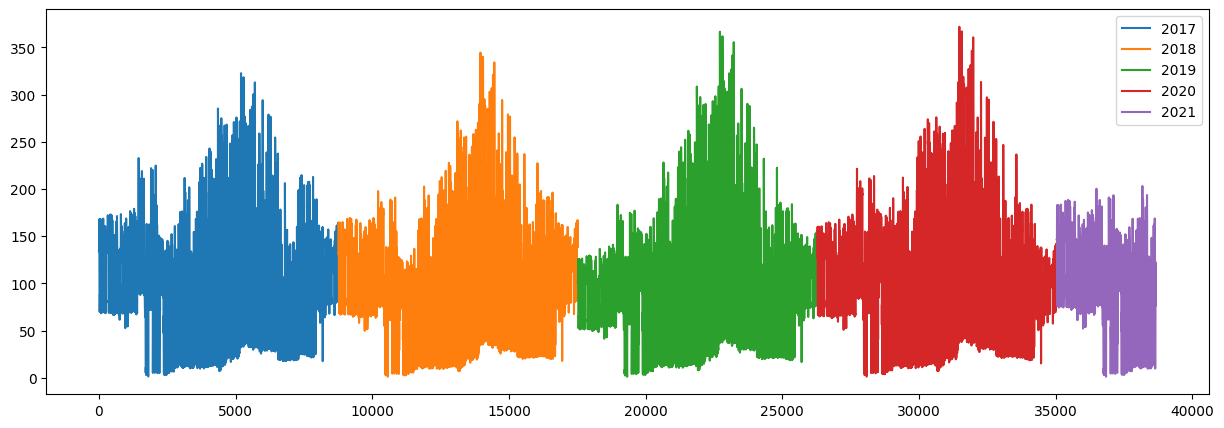

In [11]:
plt.figure(figsize=(15,5))
for year in df_final['year'].unique():
    plt.plot(df_final[df_final['year']==year]['use'])

plt.legend(df_final['year'].unique())

,year,month,day,hour,use,temp,humid,공용공간,학생자율,교수연구,연구공간,학술지원,행정지원,강의지원,sum
0,2017,1,1,1,134.459023,1.3,93.0,1.0,1.0,1.226667,20.700000,19.851373,9.380392,2.350000,55.508431
1,2017,1,1,2,133.912851,0.9,95.0,1.0,1.0,1.283663,21.661811,20.904787,9.807492,2.463059,58.120812
2,2017,1,1,3,134.201172,0.7,95.0,1.0,1.0,1.346256,22.718062,22.000000,10.308370,2.573789,60.946476
3,2017,1,1,4,133.930724,0.3,97.0,1.0,1.0,1.392898,23.505155,22.804009,10.676976,2.635739,63.014777
4,2017,1,1,5,134.012838,-0.3,97.0,1.0,1.0,1.406228,23.730104,22.909458,10.915802,2.657439,63.619031


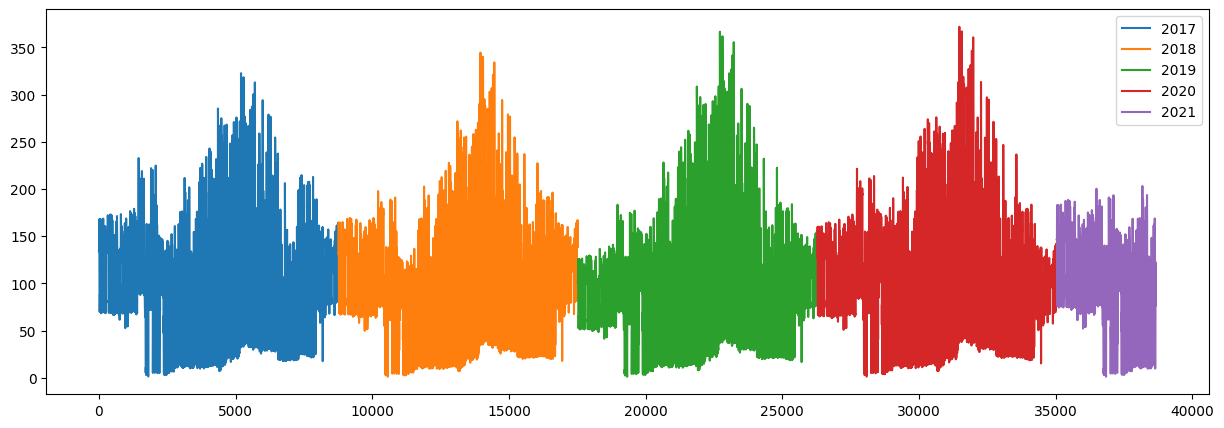

In [12]:
df_final = df_final[df_final['year']>=2017]

plt.figure(figsize=(15,5))
for year in df_final['year'].unique():
    plt.plot(df_final[df_final['year']==year]['use'])
    
display(df_final.head())
plt.legend(df_final['year'].unique())

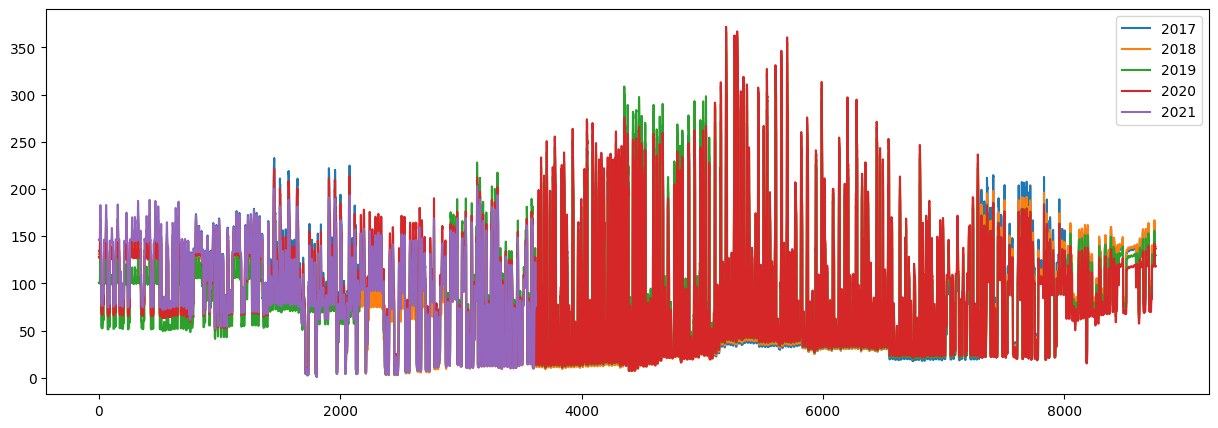

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(df_final[df_final['year']==2017].reset_index()['use'])
plt.plot(df_final[df_final['year']==2018].reset_index()['use'])
plt.plot(df_final[df_final['year']==2019].reset_index()['use'])
plt.plot(df_final[df_final['year']==2020].reset_index()['use'])
plt.plot(df_final[df_final['year']==2021].reset_index()['use'])
plt.legend(df_final['year'].unique())

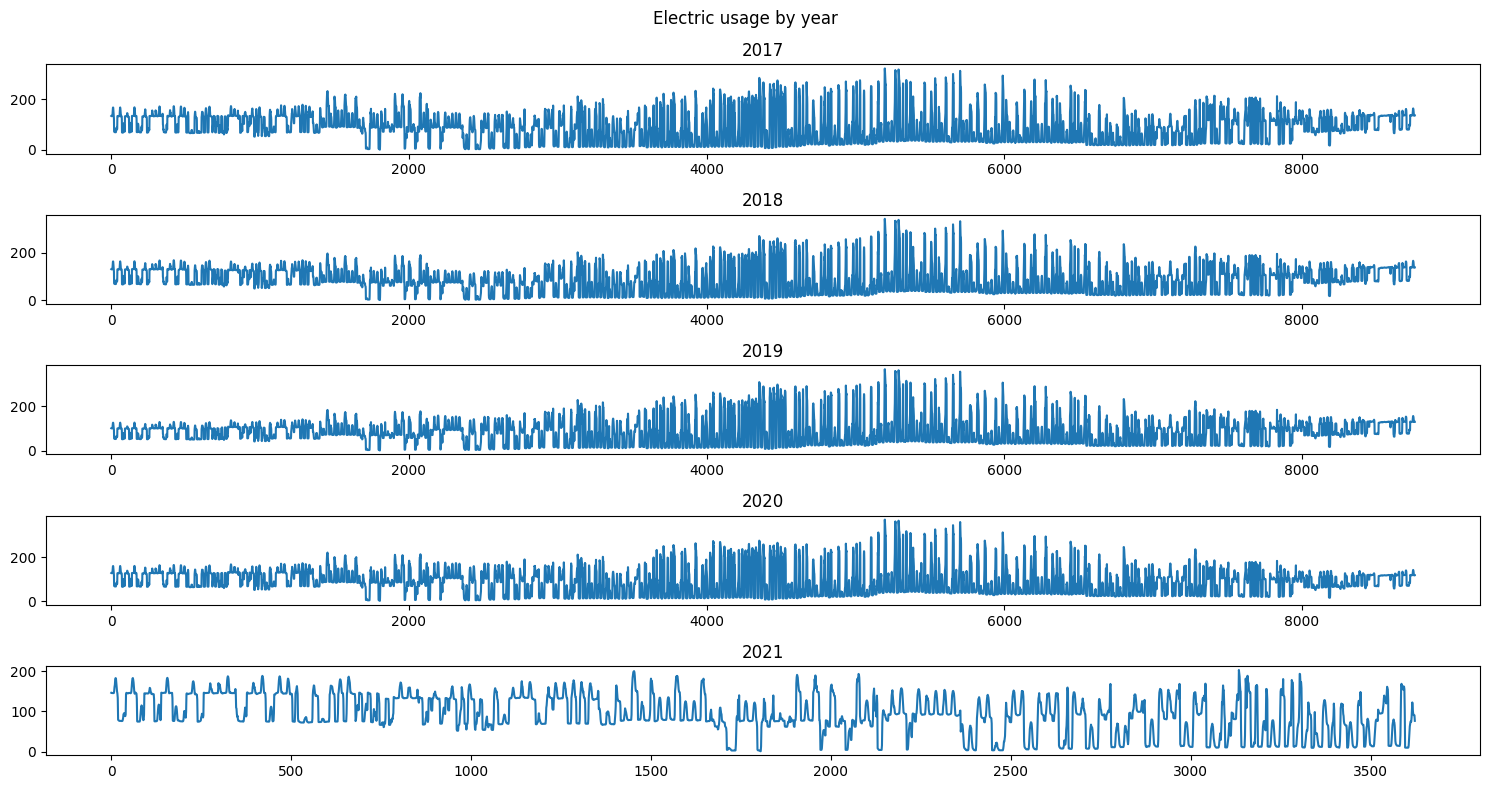

In [14]:
fig, ax = plt.subplots(5, figsize=(15, 8))
plt.suptitle('Electric usage by year')
ax[0].set_title('2017')
ax[0].plot(df_final[df_final['year']==2017].reset_index()['use'])
ax[1].set_title('2018')
ax[1].plot(df_final[df_final['year']==2018].reset_index()['use'])
ax[2].set_title('2019')
ax[2].plot(df_final[df_final['year']==2019].reset_index()['use'])
ax[3].set_title('2020')
ax[3].plot(df_final[df_final['year']==2020].reset_index()['use'])
ax[4].set_title('2021')
ax[4].plot(df_final[df_final['year']==2021].reset_index()['use'])
plt.tight_layout()

In [15]:
check_path('../temp')
df_final.to_csv('../temp/dataset_02[시간별목적별전력온습도].csv', index=False)